In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal as ss
import pickle
import scipy.linalg as sl

- Signal and dictionary upload
- Predefined data

In [4]:
name = "mati"
signal_type = "wyobrazenie"
merged= np.load(f"{name}_{signal_type}_dane.npy")
with open(f"{name}_{signal_type}_EEG.pkl", "rb") as f:
    EEG_mati = pickle.load(f)

Fs = int(EEG_mati["sampling"])
channels_names = EEG_mati['channels_names']
locs_uni = [2, 4,
          6, 7, 8, 9, 10,
          11, 12, 13, 14, 15,
          16, 17, 18, 19,20,
          22,24] # system 10-20; pozycje do wyplotowania na subplotach 5x5

locs_standard = [i for i in range(1,20)]
_, trials_count, channels_count, samples_count = merged.shape

- Shape check to examin good upload of data

In [5]:
EEG_mati['lewa'].shape

(30, 19, 2048)

SPECTROGRAM AND VISUALIZATION FUNCTIONS

In [6]:
def spectrogram(signal, hand = None, fs = Fs, nlap = True):


  # hand -> [int] 0- left, 1 - right
  
  NFFT  = int(fs)
  h = ss.windows.hamming(NFFT)

  if nlap:
    noverlap_set = NFFT - 1
  else:
    noverlap_set = NFFT - 10

  if hand != None:
    signal = signal[hand]
    print("Hand is not None") #for debugging reasons

  f, t, Sxx = ss.spectrogram(signal, fs, nperseg= NFFT, noverlap = noverlap_set, scaling = 'spectrum', window = h, axis = -1)
  Sxx_mean = np.mean(Sxx, axis = 0)

  return Sxx, t, f, Sxx_mean

In [7]:
def EEG_topology(mapa, t, f, title, f_limit=50, l=locs_uni, fs=Fs, ch_names=channels_names, ax_title = channels_names, global_scale=False, vmin = None, vmax = None):
    """
    Wizualizacja mapy czasowo-częstotliwościowej EEG dla wielu kanałów.
    
    Parametry:
    - mapa: lista lub tablica NumPy z danymi EEG (kanały na częstotliwości na czas)
    - t: oś czasu
    - f: oś częstotliwości
    - title: tytuł wykresu
    - f_limit: maksymalna częstotliwość do wyświetlenia (domyślnie 50 Hz)
    - l: układ kanałów EEG (lokalizacje w siatce subplotów)
    - fs: częstotliwość próbkowania
    - ch_names: nazwy kanałów EEG
    - global_scale: jeśli True, używa wspólnej skali kolorów dla wszystkich mapek
    """
    
    NFFT = int(fs)
    plt.figure(figsize=(10, 10))  
    plt.suptitle(title, fontsize=20, fontfamily='serif', fontweight='bold')

    # Ustalanie zakresu kolorów dla globalnej skali
    if global_scale:
        all_data = np.array([mapa[ch][:f_limit, :] for ch in range(len(ch_names))])
        if vmin == None and  vmax == None:
            vmin, vmax = np.min(all_data), np.max(all_data)  # Wspólna skala kolorów

    axes = []
    for ch in range(len(ch_names)):
        ax = plt.subplot(5, 5, l[ch])
        ax.set_title(ax_title[ch], fontsize=10)
        axes.append(ax)

        # Rysowanie mapy EEG z opcjonalną globalną skalą kolorów
        im = ax.imshow(
            mapa[ch][:f_limit, :], 
            aspect='auto', 
            origin='lower',
            extent=(t[0] - (NFFT / 2) / fs - 2, t[-1] - (NFFT / 2) / fs - 2, f[0], f[f_limit]),
            interpolation='nearest',
            cmap='coolwarm',  # Możesz zmienić np. na 'plasma', 'viridis'
            vmin=vmin, vmax=vmax  # Jeśli global_scale=True, ustawia stałą skalę kolorów
        )

        # Linia odniesienia (teraz jasnoszara, żeby była widoczna na każdej mapie)
        ax.axvline(x=0, color='w', linestyle='--', alpha=0.5)

    # Dodanie wspólnej skali kolorów tylko jeśli global_scale=True
    if global_scale:
        cbar_ax = plt.gcf().add_axes([0.92, 0.3, 0.02, 0.4])  # Wspólna oś dla colorbar
        plt.colorbar(im, cax=cbar_ax)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar
    plt.show()


- Spectrogram calculation + visualization on 10-20 topology
- Frequencies interesting in this application should be in miu band, so that's why the freq axis can be limited to have a closer look on the activated rythms

Hand is not None


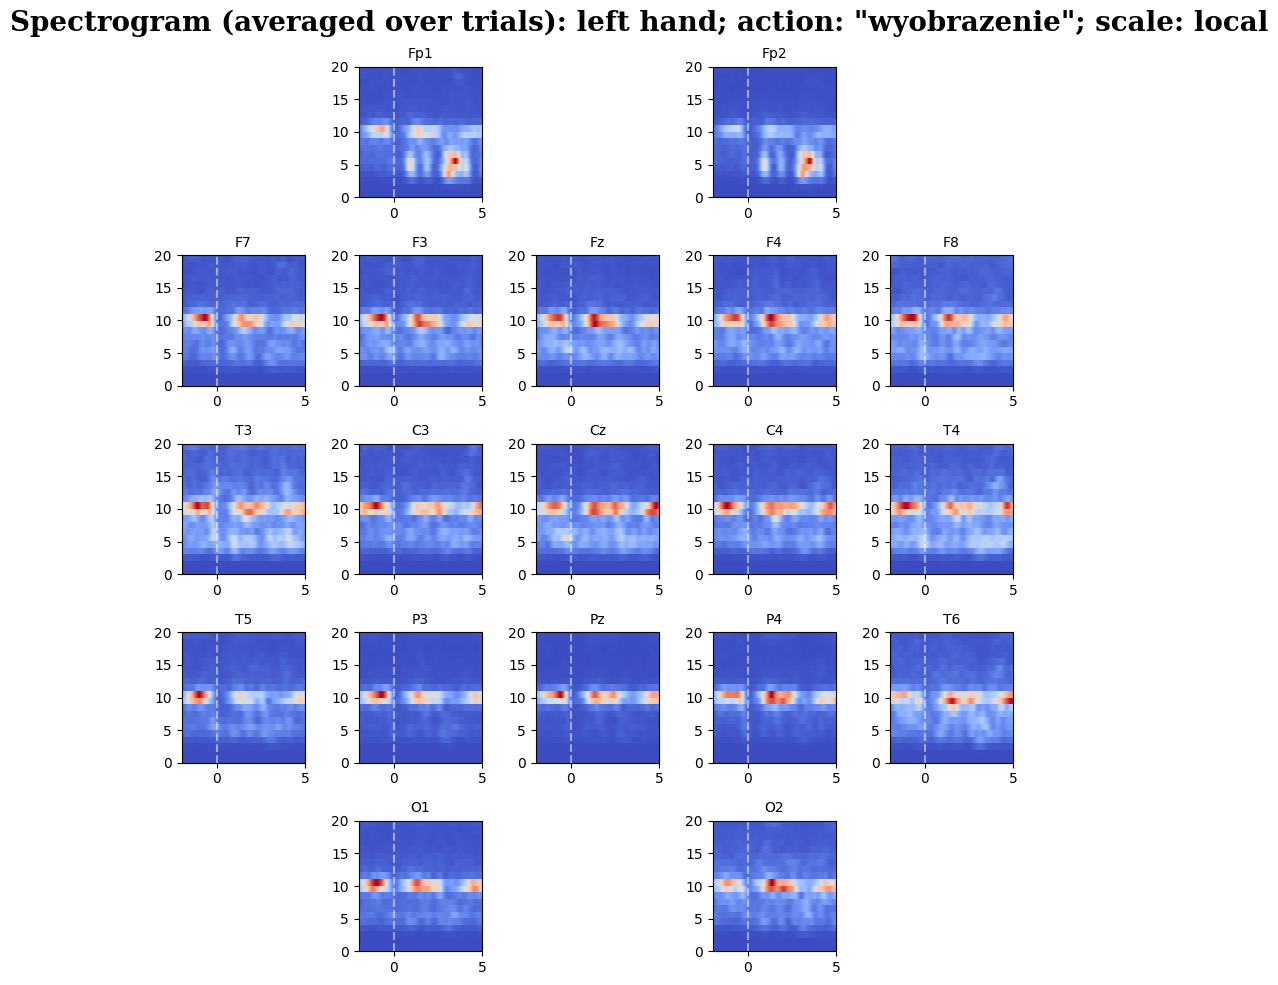

In [8]:
side = ['left', 0]
scale = 'local'
freq_limit = 20

Sxx_left, t_left, f_left, Sxx_mean_left= spectrogram(merged, side[1])
EEG_topology(Sxx_mean_left, t_left, f_left, title = f'Spectrogram (averaged over trials): {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', f_limit = freq_limit, global_scale=False)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_5615/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


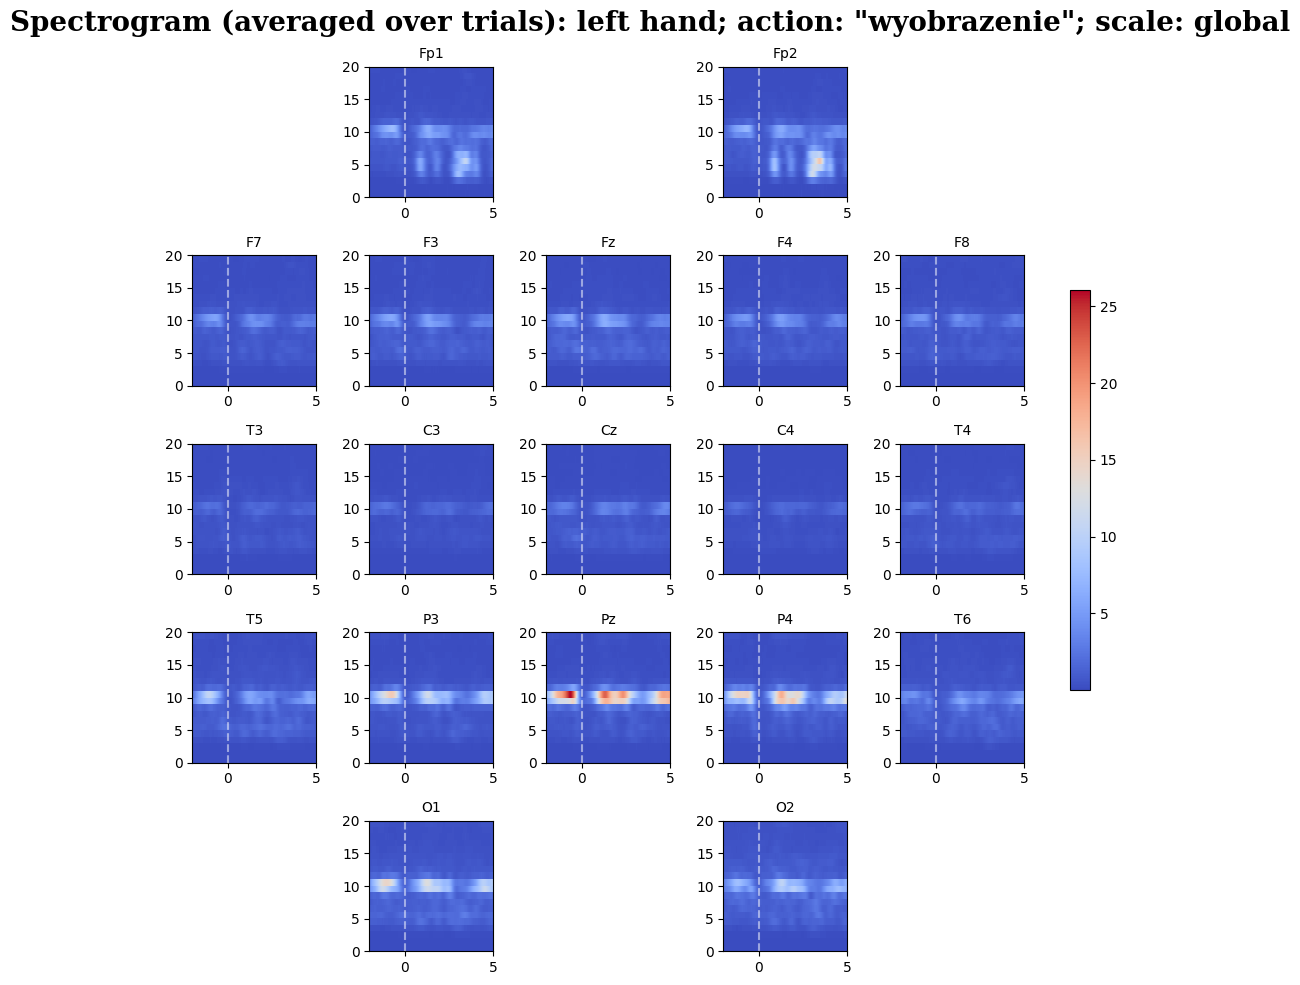

In [9]:
side = ['left', 0]
scale = 'global'
freq_limit = 20

#Sxx_left, t_left, f_left, Sxx_mean_left= spectrogram(merged, side[1]) #we don't need to calculate it one more time, because the calc from previous 
EEG_topology(Sxx_mean_left, t_left, f_left, title = f'Spectrogram (averaged over trials): {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', f_limit = freq_limit, global_scale=True)

Hand is not None


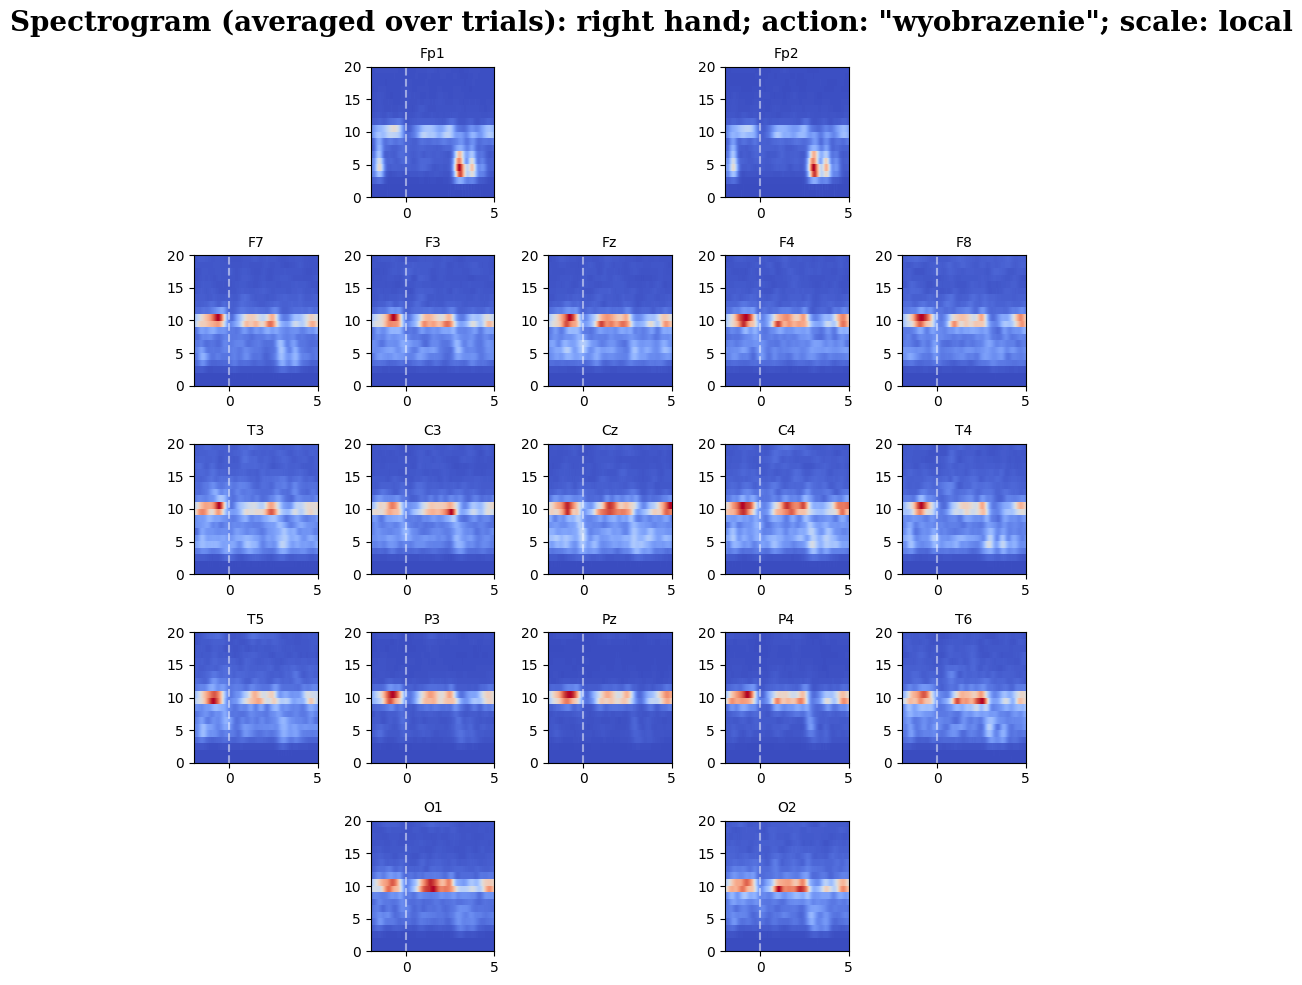

In [10]:
side = ['right', 1]
scale = 'local'
freq_limit = 20

Sxx_right, t_right, f_right, Sxx_mean_right= spectrogram(merged, side[1])
EEG_topology(Sxx_mean_right, t_right, f_right, title = f'Spectrogram (averaged over trials): {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', f_limit = freq_limit, global_scale=False)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_5615/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


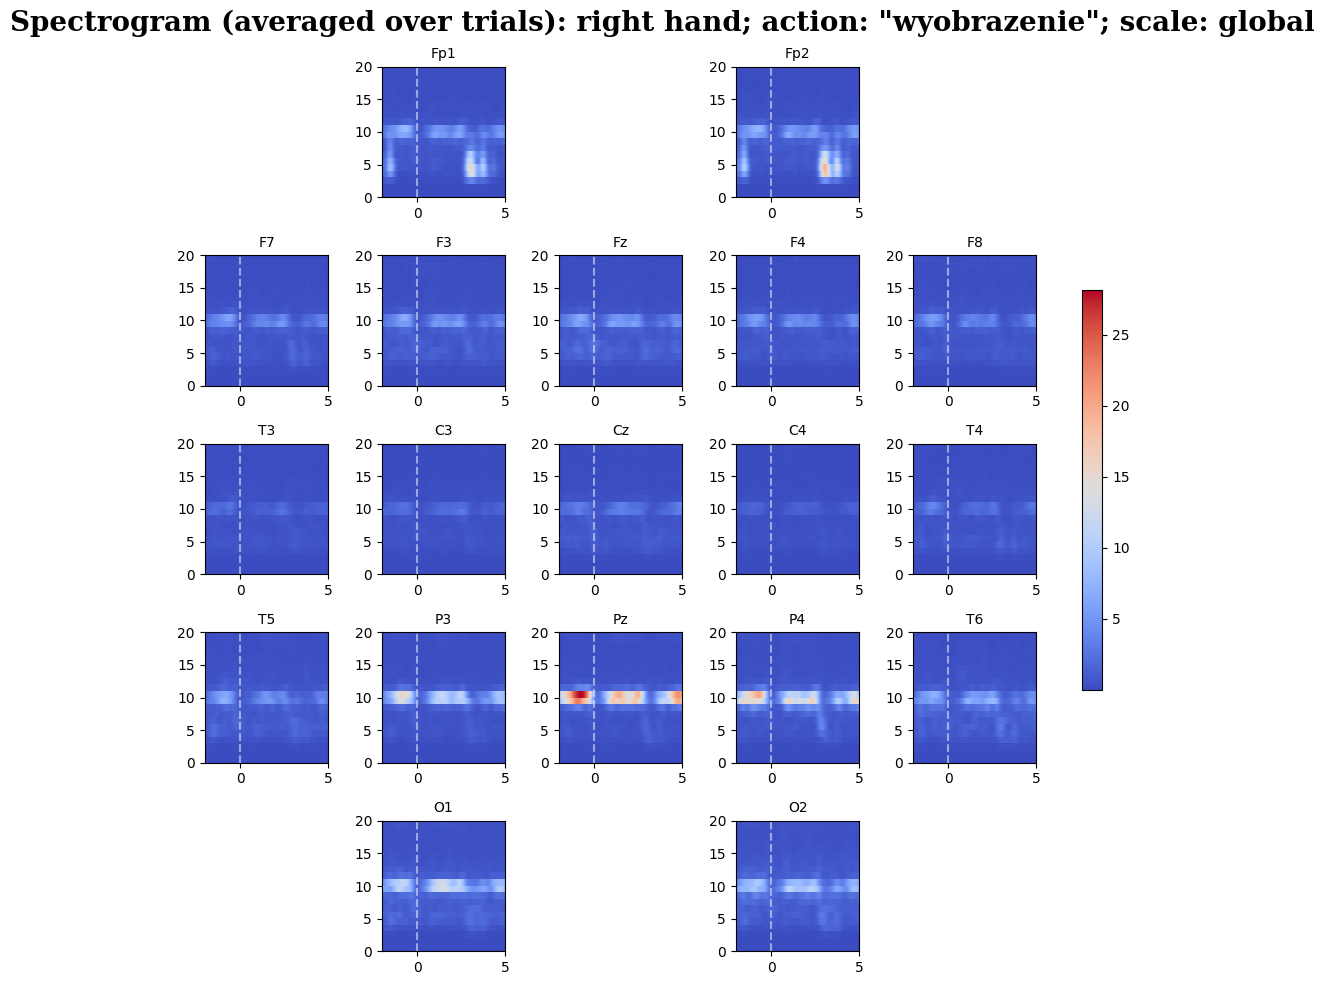

In [11]:
side = ['right', 1]
scale = 'global'
freq_limit = 20

#Sxx_right, t_right, f_right, Sxx_mean_right= spectrogram(merged, side[1])
EEG_topology(Sxx_mean_right, t_right, f_right, title = f'Spectrogram (averaged over trials): {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', f_limit = freq_limit, global_scale=True)

The interesting part is relative power to baseline. 
Used 2 paradigms: classical ERDS & statistical

b - baseline
f - chosen freq
t - chosen time

#1: S = (P(t,f) - mean(P(b,f)))/ mean(P(b,f)))
#2: S = (miu(t,f) - miu(b,f))/std(b)

In [12]:
def erds(Sxx, fs=Fs, baseline_duration=2):

    start = 0
    stop = int(baseline_duration * fs) 
    
    # Przygotowanie tablicy na wynik (relatywna moc)
    S = np.zeros(Sxx.shape[1:3] + (Sxx.shape[3],)) 
    _, ch_range, f_range, t_range = Sxx.shape

    for ch in range(ch_range):
        for f in range(f_range):
            baseline_data = Sxx[:, ch, f, start:stop]
            baseline_mean = np.mean(np.ndarray.flatten(baseline_data))

            for t in range(t_range):
                current_data = Sxx[:, ch, f, t]
                current_power = np.mean(current_data ** 2)  
                S[ch, f, t] = (current_power - baseline_mean) / baseline_mean
    
    return S

In [13]:
def relative_power(Sxx, fs = Fs):

    # choose baseline
    start = 0
    stop = int(2 * fs)

    S = np.zeros(Sxx.shape[1:3] + (Sxx.shape[3],))  
    _, ch_range, f_range, t_range = Sxx.shape


    for ch in range(ch_range):
        for f in range(f_range):
            baseline_data = Sxx[:, ch, f, start:stop]
            baseline_mean = np.mean(np.ndarray.flatten(baseline_data))
            baseline_std = np.std(np.ndarray.flatten(baseline_data))

            for t in range(t_range):
                current_data = Sxx[:, ch, f, t]  
                syg_mean = np.mean(current_data)

                S[ch, f, t ] = (syg_mean - baseline_mean) / baseline_std
    
    return S

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_5615/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


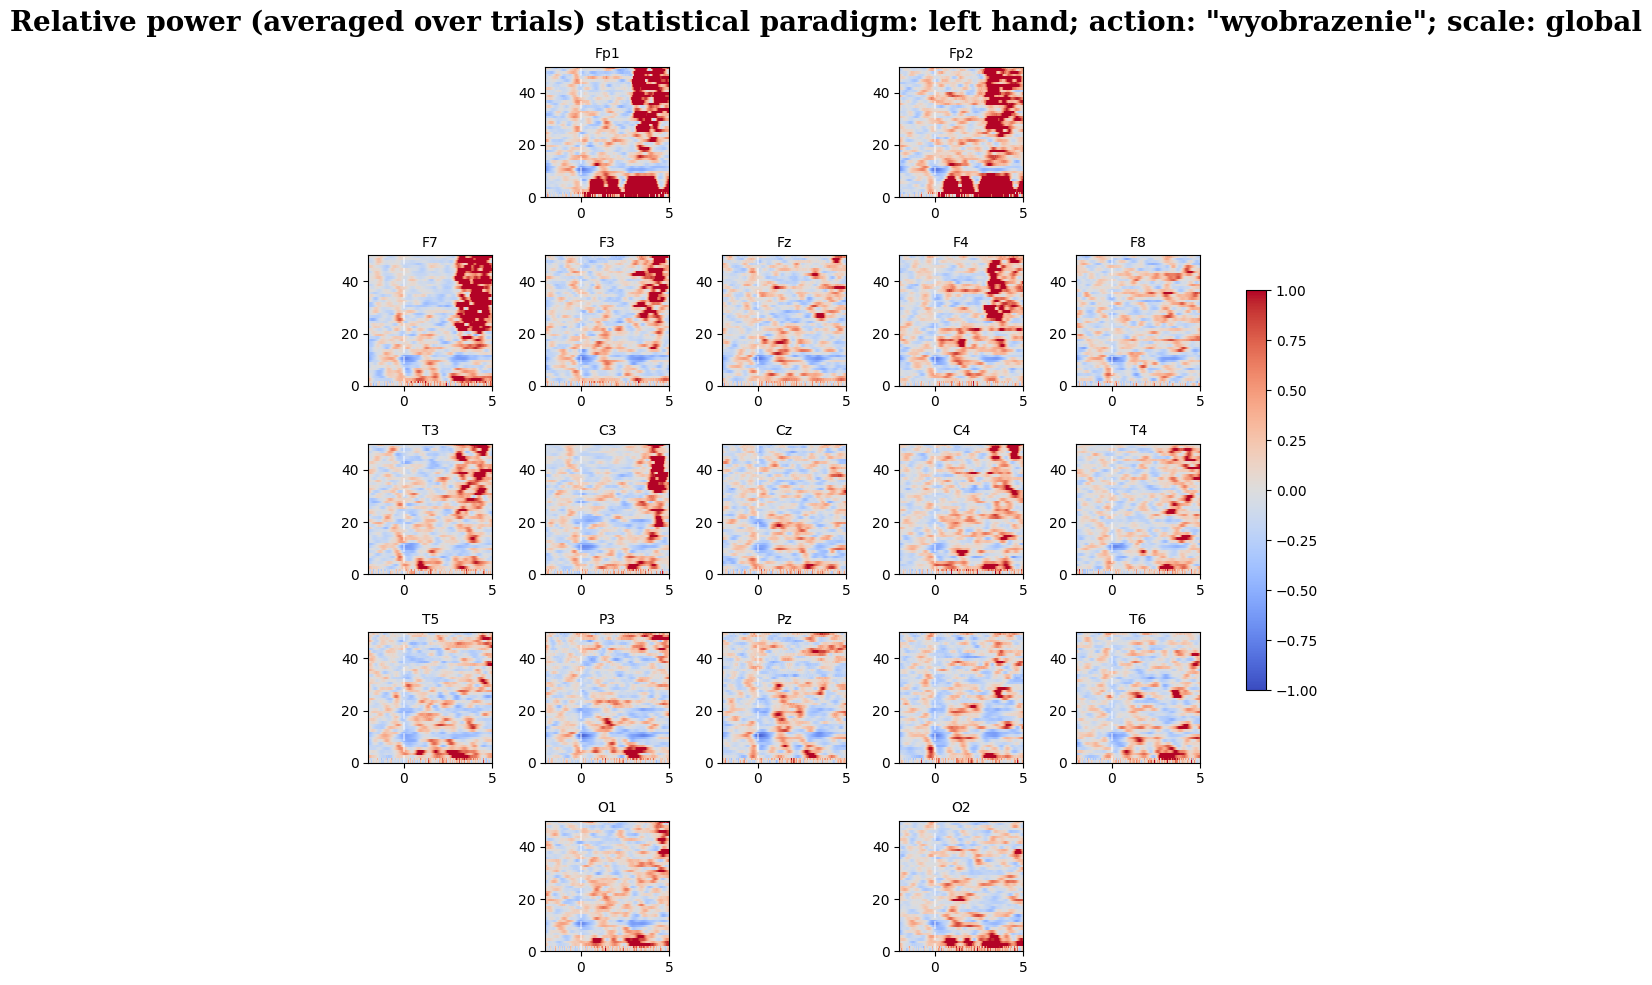

In [14]:
side = ['left', 0]
scale = 'global'
freq_limit = 50

Sxx_left_relative= relative_power(Sxx_left)
EEG_topology(Sxx_left_relative, t_left, f_left, title = f'Relative power (averaged over trials) statistical paradigm: {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -1, vmax = 1)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_5615/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


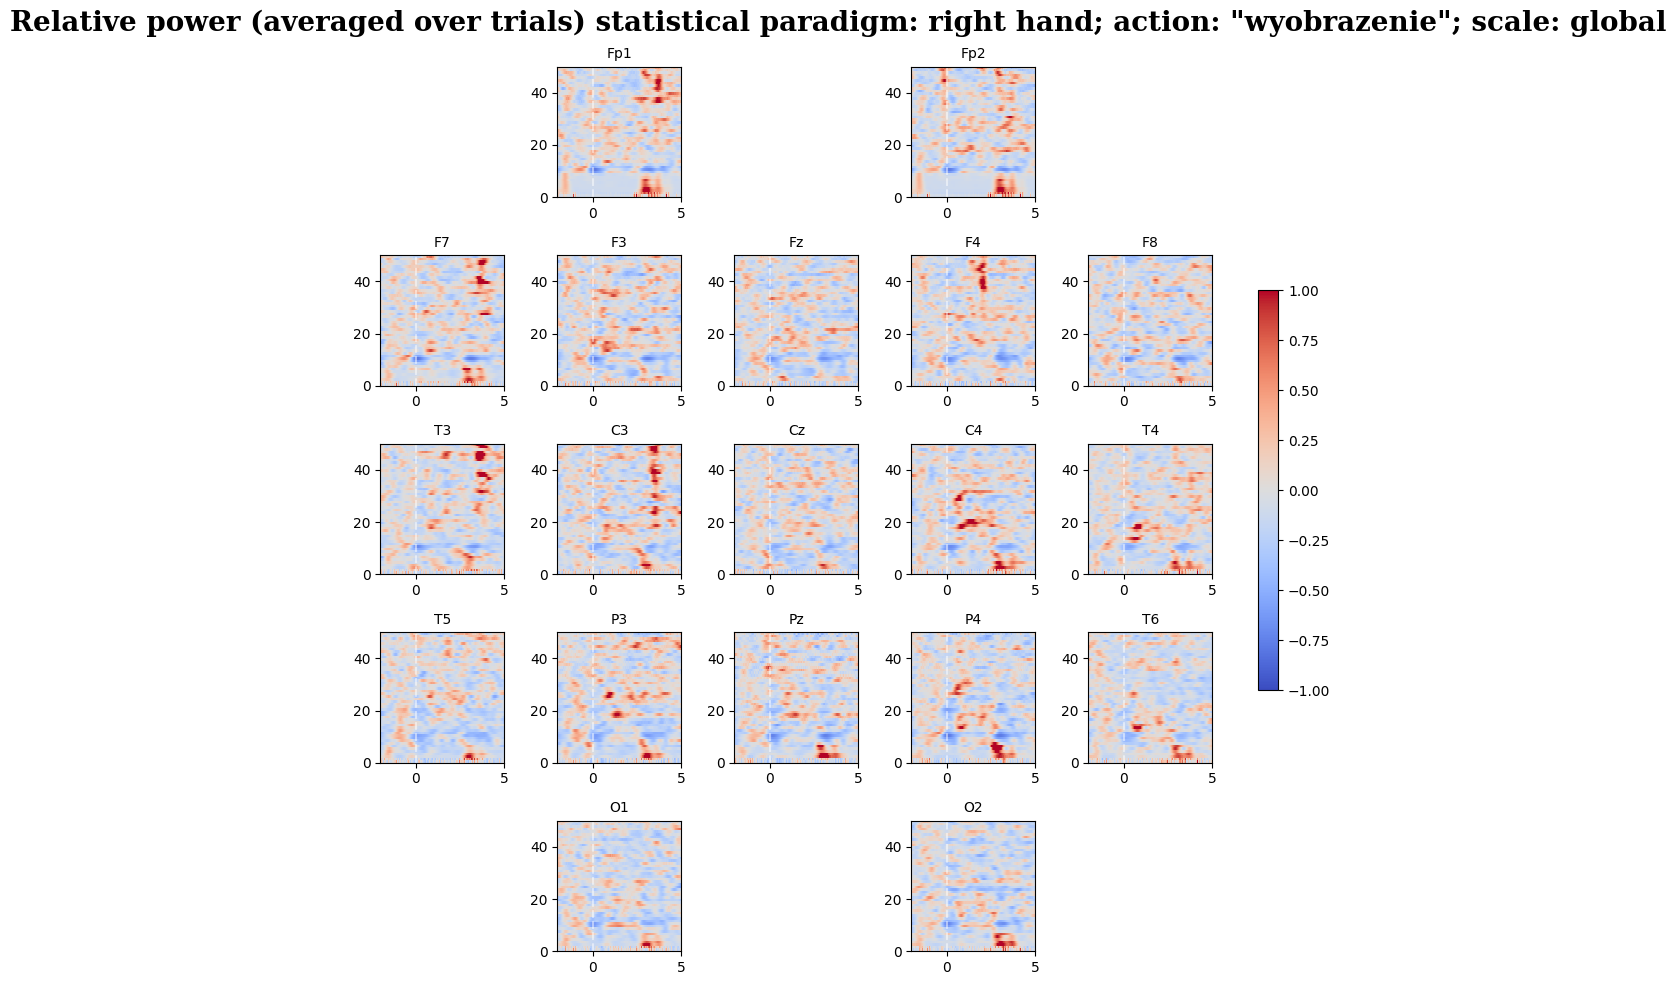

In [15]:
side = ['right', 1]
scale = 'global'
freq_limit = 50

Sxx_right_relative= relative_power(Sxx_right)
EEG_topology(Sxx_right_relative, t_right, f_right, title = f'Relative power (averaged over trials) statistical paradigm: {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -1, vmax = 1)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_5615/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


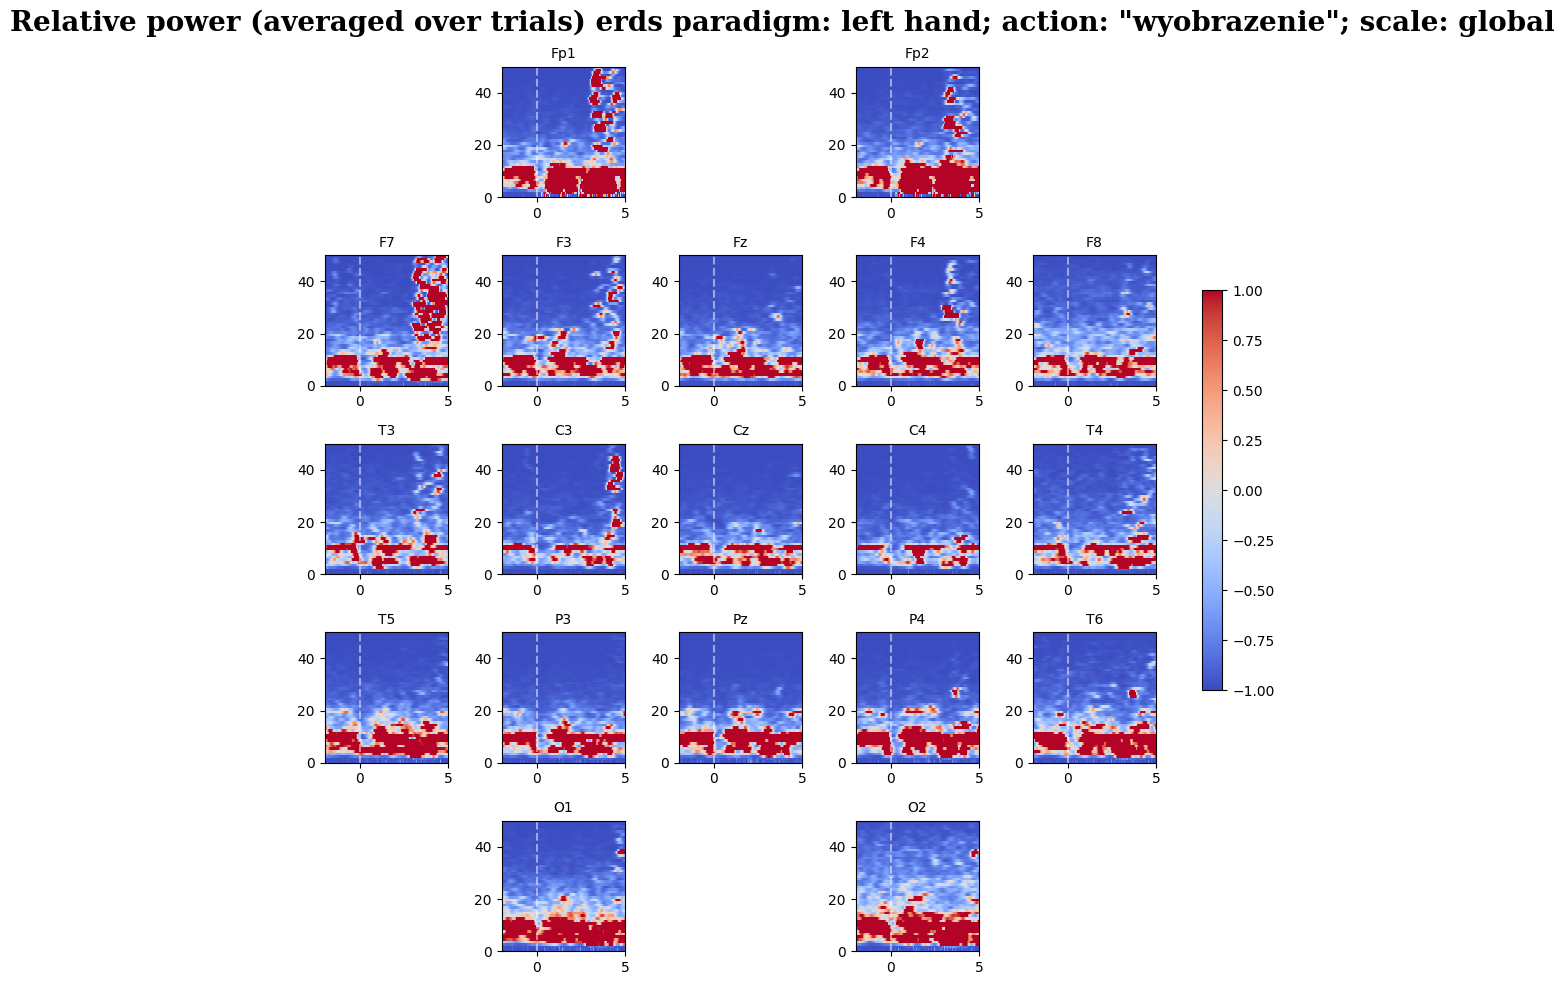

In [16]:
side = ['left', 0]
scale = 'global'
freq_limit = 50

Sxx_left_erds= erds(Sxx_left)
EEG_topology(Sxx_left_erds, t_left, f_left, title = f'Relative power (averaged over trials) erds paradigm: {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -1, vmax = 1)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_5615/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


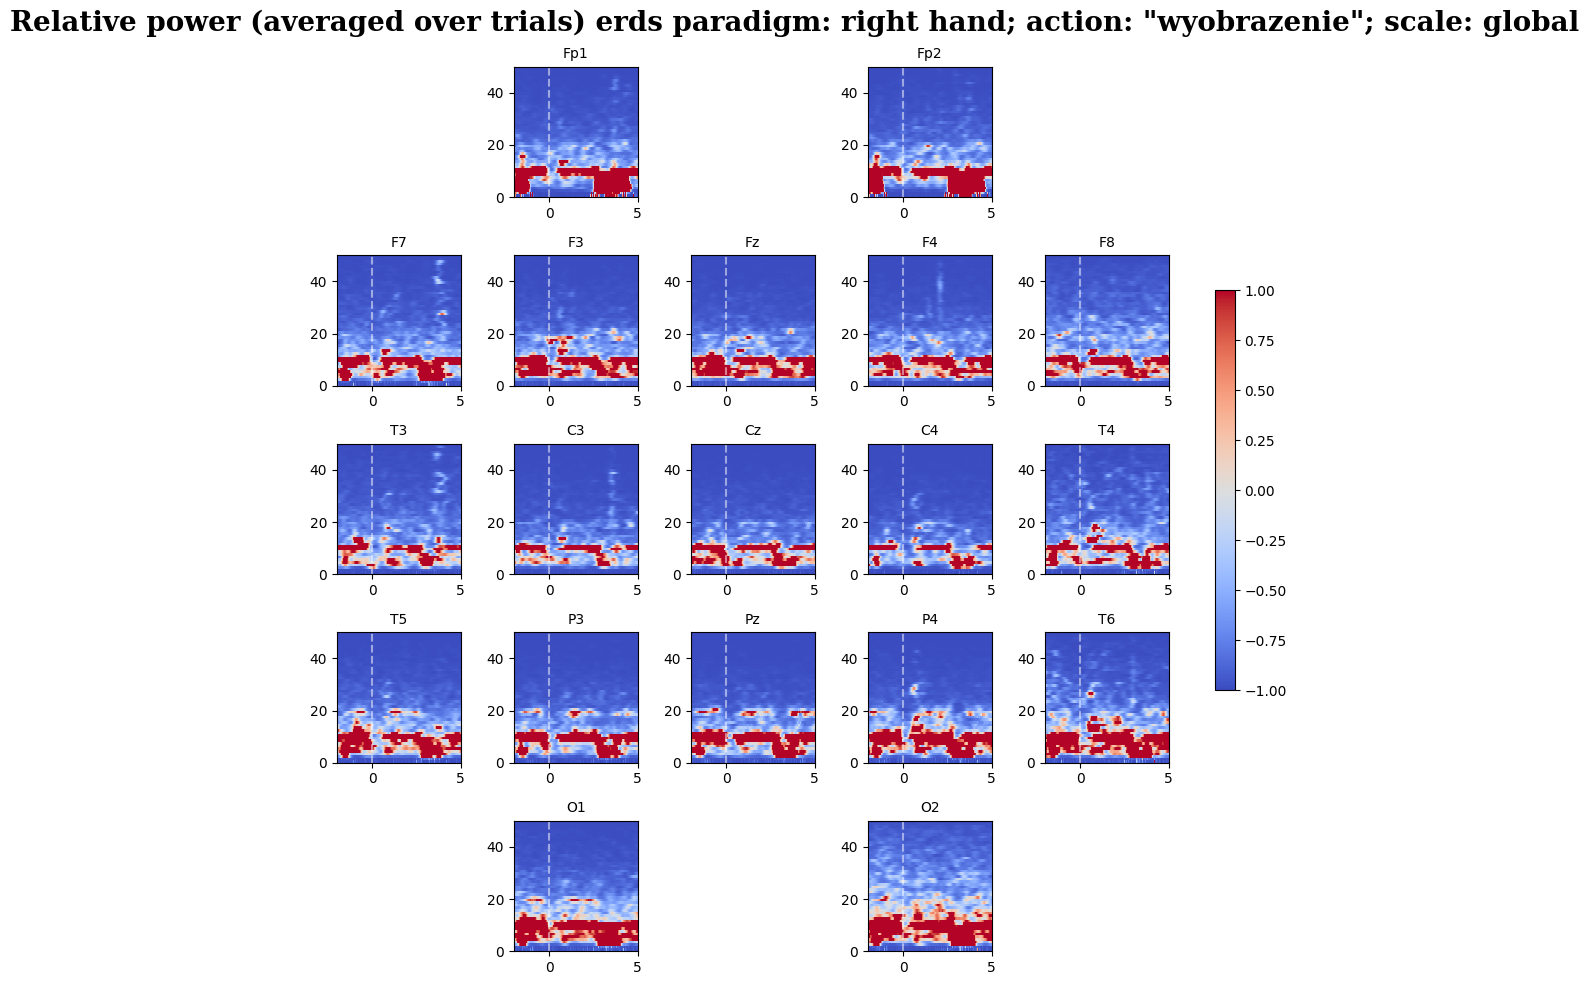

In [17]:
side = ['right', 1]
scale = 'global'
freq_limit = 50

Sxx_right_erds= erds(Sxx_right)
EEG_topology(Sxx_right_erds, t_right, f_right, title = f'Relative power (averaged over trials) erds paradigm: {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -1, vmax = 1)

Spacial filters - COMMON PATERNS SEPARATION (CPS)

We decided to NOT divide by trace!

In [18]:
from scipy.stats import Covariance

In [19]:
T = samples_count/Fs
t = np.arange(0,T, 1/Fs)

baseline_ind = np.where(t<2)[0]
move_ind = np.where(t>2)[0]

R_L = np.zeros((channels_count,channels_count))
R_P = np.zeros((channels_count,channels_count))
trial_count = 30

for trial in range(trial_count):
    L = EEG_mati['lewa'][trial, :, move_ind]
    tmp = np.cov(L, rowvar = False)
    R_L = R_L + tmp#/ np.trace(tmp)

    P = EEG_mati['prawa'][trial, :, move_ind]
    tmp = np.cov(P, rowvar = False)
    R_P = R_P + tmp#/ np.trace(tmp)

R_L = R_L/ trials_count
R_P = R_P/ trials_count

Lambda, W = sl.eigh(R_L, R_P)

LinAlgError: The leading minor of order 19 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

I left this error to display the trouble we went across, but to overcome it we used another Covariance model

In [20]:
from sklearn.covariance import LedoitWolf

In [21]:
T = samples_count/Fs
t = np.arange(0,T, 1/Fs)

baseline_ind = np.where(t<2)[0]
move_ind = np.where(t>2)[0]

R_L = np.zeros((channels_count,channels_count))
R_P = np.zeros((channels_count,channels_count))
trial_count = 30

for trial in range(trial_count):
    estimator = LedoitWolf()

    L = EEG_mati['lewa'][trial, :, move_ind[0]:]
    estimator.fit(L.T)  
    tmp = estimator.covariance_ 
    R_L = R_L + tmp#/ np.trace(tmp)

    estimator2 = LedoitWolf()
    P = EEG_mati['prawa'][trial, :, move_ind[0]:]
    estimator2.fit(P.T)  # Uwaga: musisz transponować, bo fit oczekuje kształtu (n_samples, n_features)
    tmp = estimator2.covariance_
    R_P = R_P + tmp#/ np.trace(tmp)

R_L = R_L/ trials_count
R_P = R_P/ trials_count

Lambda, W = sl.eigh(R_L, R_P)


Problem resolved :))

Let's examin the W vector and then have a close-up on smaller values

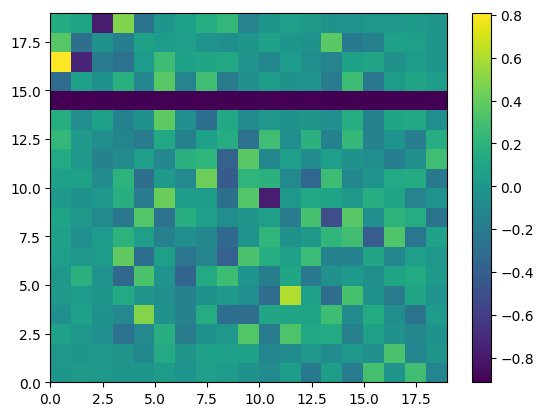

In [22]:
plt.pcolor(W.T)
plt.colorbar()

Then it's time to take a topology-oriented look and see how the chosen vector W (we have 19 vectors) looks on the head topology

In [24]:
def csp_topology(wektor, title, l=locs_uni, ch_names=channels_names, 
                 ax_title=channels_names, global_scale=False, vmin=None, vmax=None):

    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=20, fontfamily='serif', fontweight='bold')

    # Automatyczne ustawienie zakresu kolorów
    if not global_scale:
        vmin, vmax = np.min(wektor), np.max(wektor)

    for ch in range(len(ch_names)):
        ax = plt.subplot(5, 5, l[ch])
        ax.set_title(ax_title[ch], fontsize=10)

        # Tworzenie macierzy 1x1 zawierającej tylko wartość wektora dla danego kanału
        color_matrix = np.array([[wektor[ch]]])

        # Wyświetlanie wartości jako kolor
        im = ax.imshow(color_matrix, cmap='coolwarm', vmin=vmin, vmax=vmax)

        # Wyświetlanie wartości liczbowej na środku
        ax.text(0, 0, f"{wektor[ch]:.2f}", ha='center', va='center', fontsize=12, 
                color='black', fontweight='bold')

        # Usunięcie osi dla czystego wyglądu
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)

    # Dodanie wspólnej skali kolorów jeśli global_scale=True
    if global_scale:
        cbar_ax = plt.gcf().add_axes([0.92, 0.3, 0.02, 0.4])  # Oś dla colorbar
        plt.colorbar(im, cax=cbar_ax)

    plt.tight_layout(rect=[0, 0, 0.9, 1])  
    plt.show()

W_topology calculation needs to be done only once. The values are now absolute. 

In [25]:
W_topology = np.abs(np.linalg.inv(W))

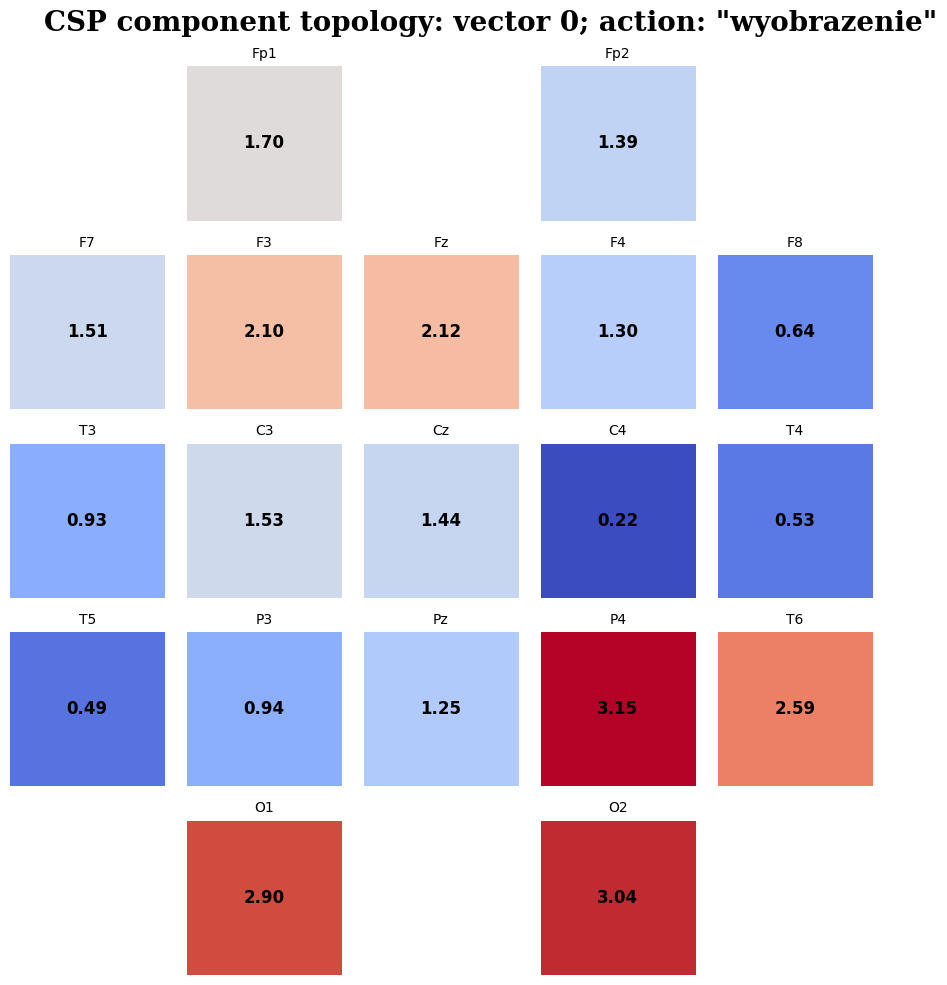

In [27]:
vector = '0'
scale = 'global'

W_00 = W_topology[0]
csp_topology(W_00, title = f'CSP component topology: vector {vector}; action: "{signal_type}"')

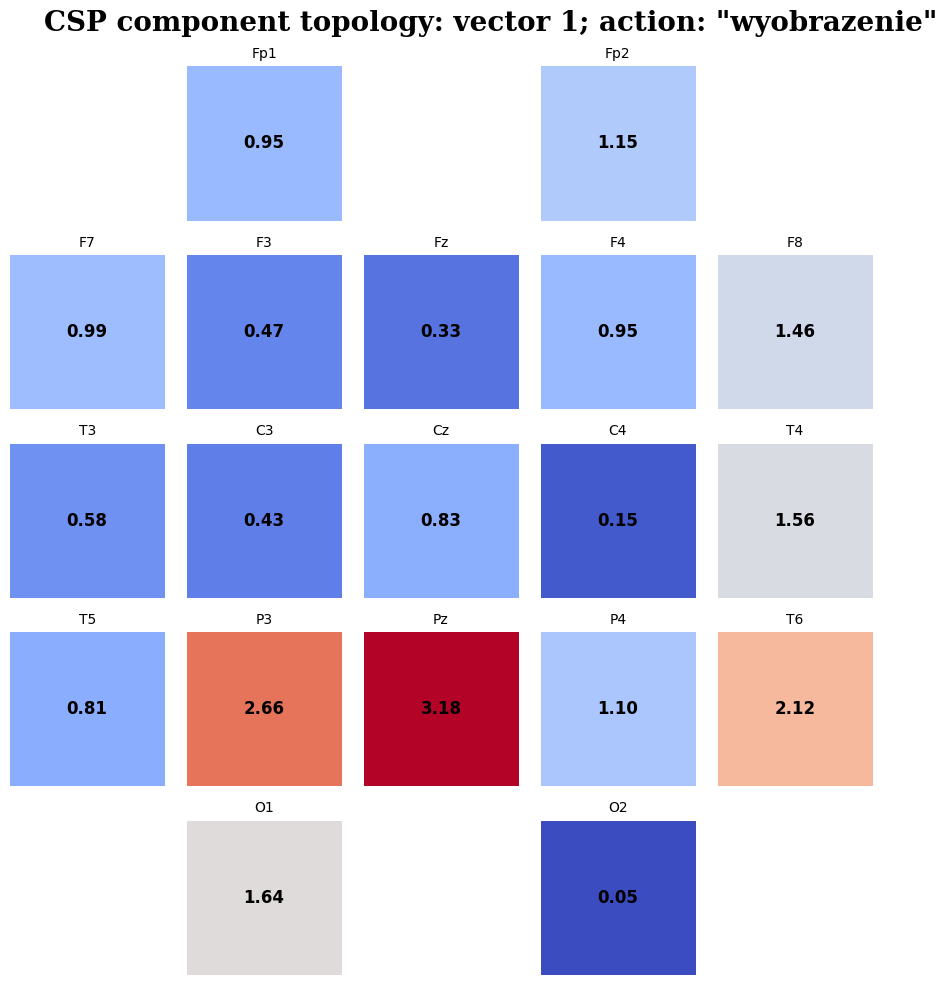

In [26]:
vector = '1'
scale = 'global'

W_01 = W_topology[1]
csp_topology(W_01, title = f'CSP component topology: vector {vector}; action: "{signal_type}"')

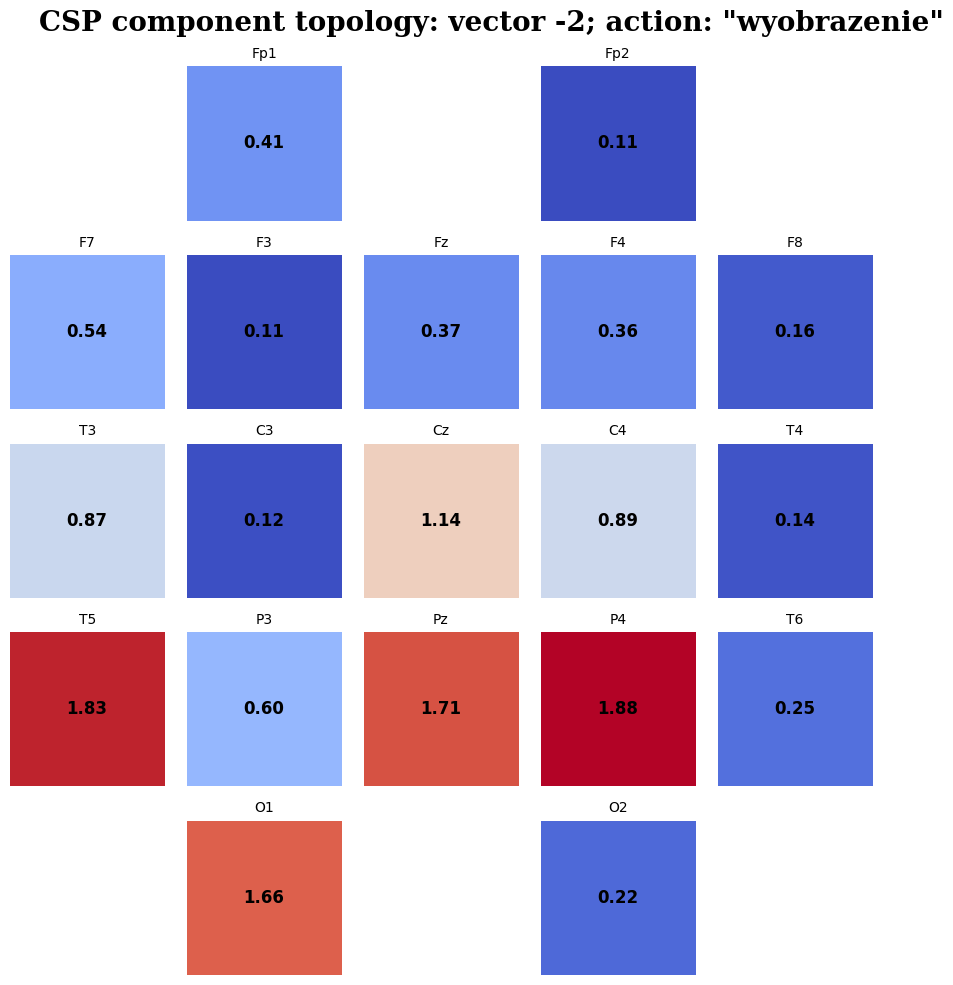

In [28]:
vector = '-2'
scale = 'global'

W_2 = np.abs(W_topology[-2])
csp_topology(W_2, title = f'CSP component topology: vector {vector}; action: "{signal_type}"')

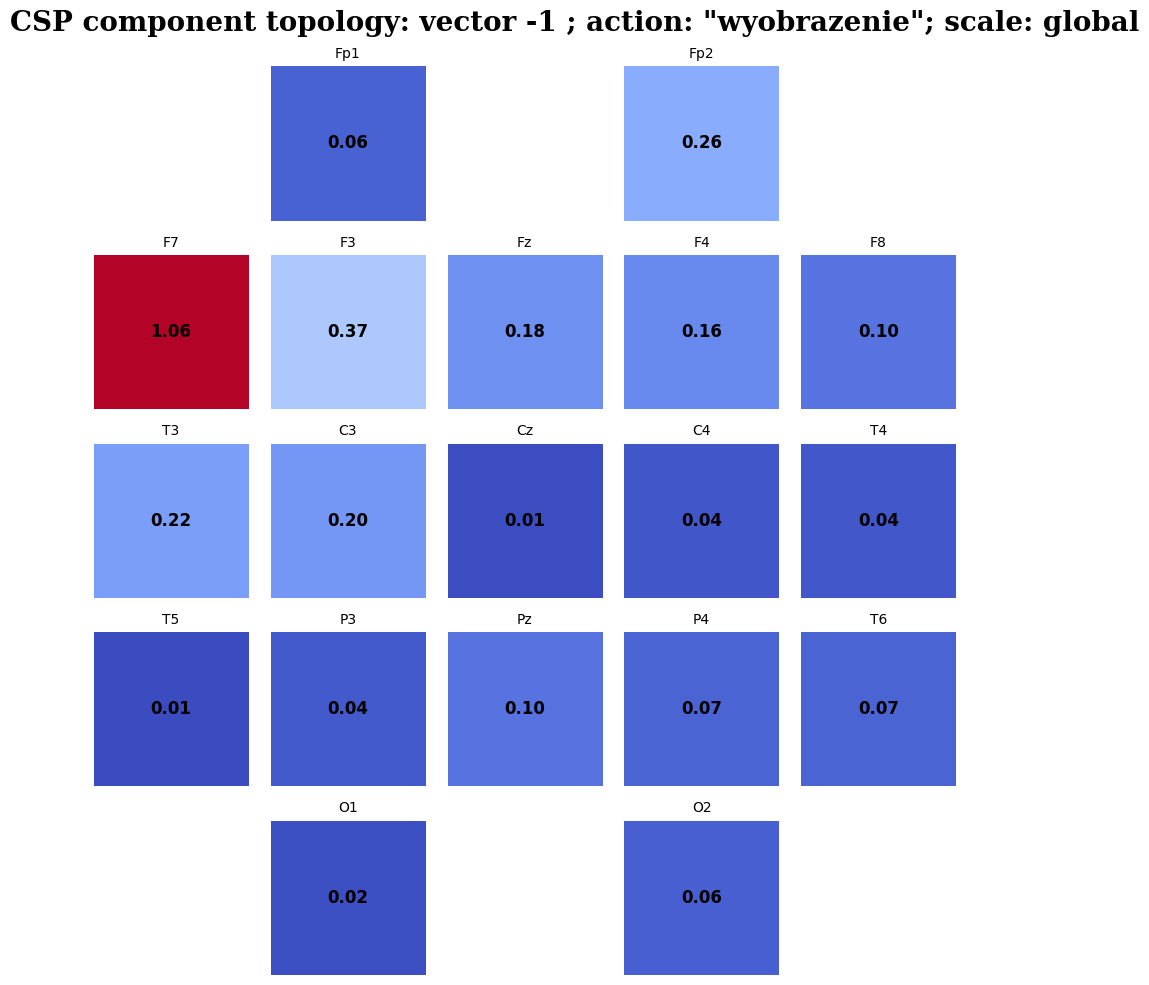

In [29]:
side = '-1'
scale = 'global'

W_1 = np.abs(W_topology[-1])
csp_topology(W_1, title = f'CSP component topology: vector {side} ; action: "{signal_type}"; scale: {str(scale)}')

Let's choose vector 1! As we want to display differences it is also a good idea to choose from the front of lambda values & the topology is very attractive 

It is wanted to be resolved by eigh function: a @ v = b @ v @ w

In [33]:
Lambda #values examination

array([0.81434252, 0.87999836, 0.94954463, 0.95961848, 0.97799679,
       0.99221389, 1.02652489, 1.03445691, 1.06257944, 1.08302393,
       1.09135575, 1.10158353, 1.13101479, 1.18137107, 1.20250259,
       1.2466423 , 1.34781599, 1.40154554, 1.58979188])

Mind the "fancy indexing"

In [34]:
S_L = np.zeros((trials_count, channels_count, len(move_ind)))
S_P = np.zeros((trials_count, channels_count, len(move_ind)))

In [35]:
L = EEG_mati['lewa'][:, :, move_ind]
P = EEG_mati['prawa'][:, :, move_ind]

for trial in range(trials_count):
    S_L[trial, :, :] = W.T @ L[trial, :, :]
    S_P[trial, :, :] = W.T @ P[trial, :, :]

I checked and S_L and S_P hold non-zero values (after fixing a typo in the word "trial" in the loop)

- Let's add +2 to t_left_cps, because we don't involve beaseline
- We need to deteriorate the resolusion of time, because 1280 would be too much for classification (i change step in noverlap from 1 to 10)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_5615/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


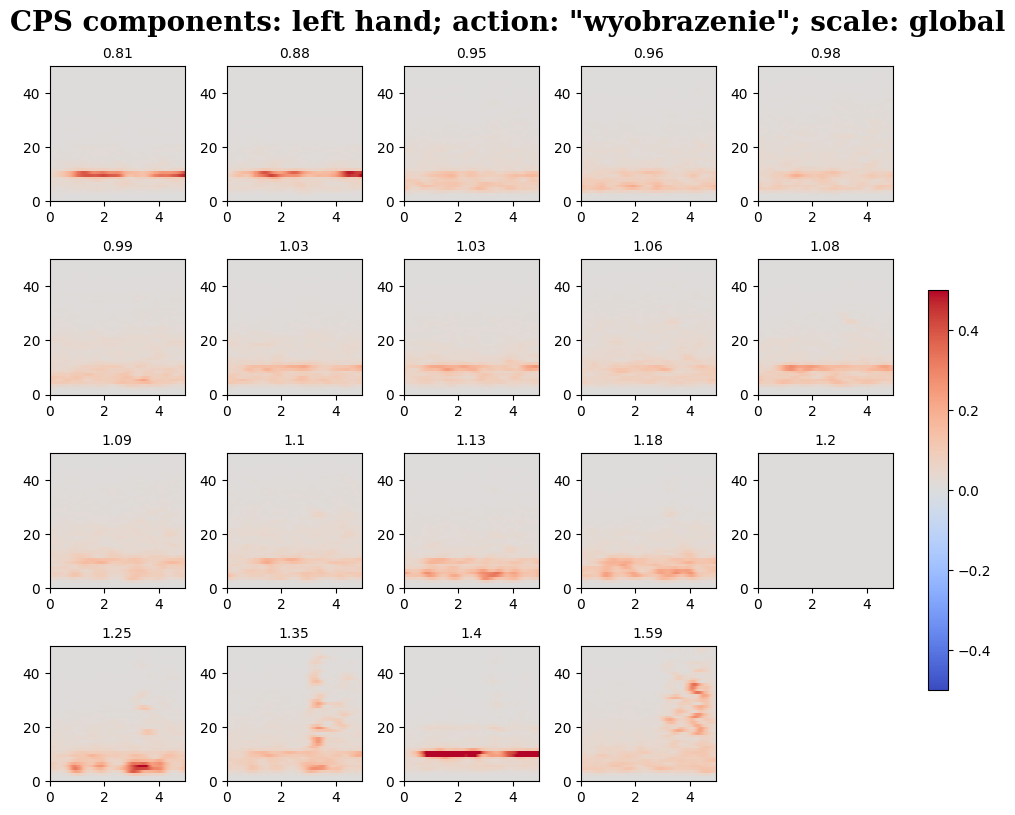

In [36]:
side = 'left'
scale = 'global'
freq_limit = 50

rounded_Lambda = list(map(lambda x: round(x, 2), Lambda))

Sxx_left_cps, t_left_cps, f_left_cps, Sxx_mean_left_cps = spectrogram(S_L, nlap = False)
t_left_cps = t_left_cps + 2
EEG_topology(Sxx_mean_left_cps, t_left_cps, f_left_cps, title = f'CPS components: {side} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -0.5, vmax = 0.5, ax_title = rounded_Lambda, l = locs_standard)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_5615/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


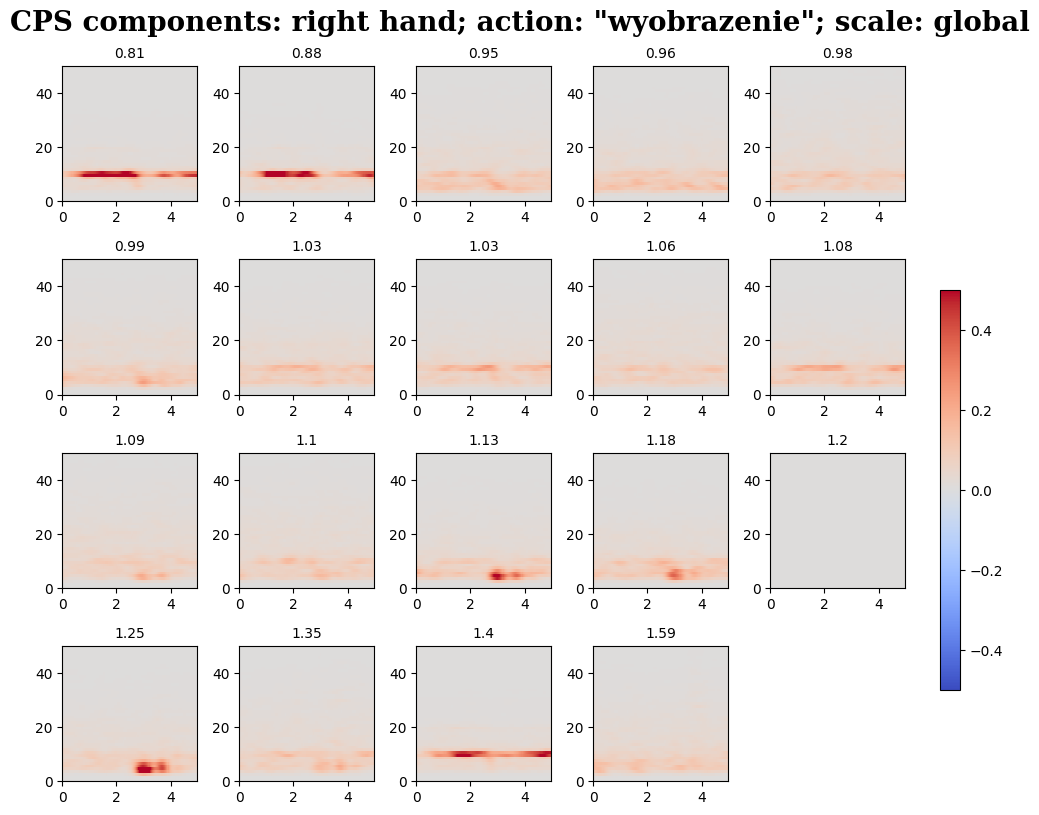

In [37]:
side = 'right'
scale = 'global'
freq_limit = 50

rounded_Lambda = list(map(lambda x: round(x, 2), Lambda))

Sxx_right_cps, t_right_cps, f_right_cps, Sxx_mean_right_cps = spectrogram(S_P, nlap = False)
t_right_cps = t_right_cps + 2

EEG_topology(Sxx_mean_right_cps, t_right_cps, f_right_cps, title = f'CPS components: {side} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -0.5, vmax = 0.5, ax_title = rounded_Lambda, l = locs_standard)

Let's work on classification problem for the last component - corresponding to the eigenvalues 1.3

In [44]:
def data_acquisition_left(Sxx_left_cps, component_ind):
    # Pobranie widma dla lewej strony
    #ucinamy częstotliwości do 30 Hz

    #trail - freqs - time 
    spectrogram_left = Sxx_left_cps[:, component_ind, :30, :]
    trial_count = 30
    time_points = spectrogram_left.shape[-1]

    sig_left = np.zeros((30,30 * time_points + 1))

    for trial in range(trial_count):
        sig_left[trial][0:30 * time_points] += spectrogram_left[trial].reshape(-1)

    return pd.DataFrame(sig_left)


df_left = data_acquisition_left(Sxx_left_cps, 1)

In [45]:
def data_acquisition_right(Sxx_right_cps, component_ind):
    # Pobranie widma dla lewej strony
    #ucinamy częstotliwości do 30 Hz

    #trail - freqs - time 
    spectrogram_right = Sxx_right_cps[:, component_ind, :30, :]
    trial_count = 30
    time_points = spectrogram_right.shape[-1]

    sig_right = np.zeros((30,30 * time_points + 1))
    # Dodanie 30 zer na końcu ostatniego wymiaru (Z -> Z+30)
    for trial in range(trial_count):
        sig_right[trial][0:30 * time_points] += spectrogram_right[trial].reshape(-1)
        sig_right[trial][-1] += 1

    return pd.DataFrame(sig_right)


df_right = data_acquisition_right(Sxx_right_cps, 1)

We have 30 vectors (trails) per left and right and the last value 0 - left/ 1- right is label

In [46]:
df_left.rename(columns={df_left.columns[3840]: "label"}, inplace=True)
df_right.rename(columns={df_right.columns[3840]: "label"}, inplace=True)


In [47]:
dataset = pd.concat((df_left, df_right), axis = 0)

In [48]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,3831,3832,3833,3834,3835,3836,3837,3838,3839,label
0,3.013096e-05,1.450685e-03,0.000899,1.977285e-06,1.357961e-03,1.230696e-04,2.814099e-03,9.536789e-05,1.023745e-03,2.327981e-03,...,0.000315,0.000261,0.000352,0.000459,0.001215,0.002808,0.005979,0.010088,0.016102,0.0
1,1.802549e-05,9.247415e-05,0.001395,6.286067e-05,4.575402e-04,5.804961e-06,5.996030e-05,1.270400e-03,3.975663e-05,6.055173e-10,...,0.012364,0.013837,0.014774,0.015742,0.016588,0.016539,0.016674,0.015790,0.015082,0.0
2,6.460128e-06,1.853581e-04,0.000386,1.025606e-04,5.860626e-04,9.748049e-04,6.775993e-04,2.538821e-04,2.080826e-03,2.559835e-04,...,0.000592,0.001034,0.001466,0.002190,0.002883,0.003679,0.004367,0.005012,0.005834,0.0
3,4.926857e-05,4.377481e-05,0.000027,4.070974e-05,8.645221e-08,2.270958e-04,1.319141e-03,3.529788e-05,3.025623e-04,6.711790e-04,...,0.005468,0.006892,0.007485,0.008633,0.008869,0.009335,0.008979,0.008494,0.008852,0.0
4,1.827009e-03,1.259049e-03,0.000454,1.993412e-04,6.849641e-04,1.075759e-05,1.001291e-03,1.597174e-04,7.002151e-04,6.317643e-05,...,0.011730,0.010356,0.008625,0.007617,0.005868,0.004646,0.003364,0.002684,0.002144,0.0
5,1.358120e-03,6.251176e-07,0.000152,1.129054e-03,4.258399e-06,3.532046e-07,1.975578e-06,2.248827e-03,7.582156e-05,1.071548e-03,...,0.003033,0.003595,0.004781,0.005927,0.008934,0.011303,0.014567,0.016343,0.019975,0.0
6,2.724855e-04,1.338458e-05,0.000004,1.828466e-04,5.331839e-05,4.623379e-03,2.705731e-03,2.161667e-04,4.042856e-04,1.644474e-03,...,0.013815,0.012035,0.010185,0.009953,0.008788,0.009552,0.008121,0.008889,0.007700,0.0
7,6.058324e-04,5.160149e-05,0.000007,3.438660e-04,7.637337e-04,1.138152e-03,1.349588e-04,3.151221e-04,1.068991e-05,2.410763e-03,...,0.018805,0.017029,0.016600,0.014754,0.014302,0.012593,0.011145,0.009631,0.009801,0.0
8,1.172725e-06,3.173505e-04,0.000106,1.155023e-03,5.572149e-08,7.092507e-04,1.133260e-03,3.442241e-04,3.879574e-04,1.471669e-05,...,0.002222,0.001793,0.001598,0.002074,0.001774,0.001503,0.001468,0.001527,0.001538,0.0
9,1.379351e-03,2.469583e-03,0.000201,1.452869e-04,3.072184e-04,1.016001e-03,1.517711e-04,1.073281e-04,7.011385e-05,1.001262e-05,...,0.001437,0.002611,0.004300,0.005752,0.007088,0.008822,0.008257,0.008583,0.009125,0.0


In [49]:
dataset.to_csv('datasets/dataset_imagine2.csv', index=False)